In [1]:
import numpy as np
import pandas as pd
import struct
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import seaborn as sns
sns.set_style('darkgrid')
import sys
import os
import seaborn
from  matplotlib import pyplot

In [2]:
import io

# functions for reading files
        
def read_data(start, end, paths, data_name, label_name):
    data = []
    for path in paths:
        for i in range(start, end + 1):
            data_path = f'{path[0]}/{data_name}_{i:04}'
            if(os.path.isfile(data_path)):
                data.append(pd.read_csv(data_path))
                data[-1]['conf'] = i
                data[-1][label_name] = path[1]
    
    return pd.concat(data)

In [1]:
# save image
def save_image(image_path, image_name, fg):
    try:
        os.makedirs(image_path)
    except:
        pass
    
    output_path = f'{image_path}/{image_name}'
    fg.savefig(output_path, dpi=400, facecolor='white')

In [16]:
# functions for density of wrapped and unwrapped clusters

def data_process_density(data):
    return data.groupby(['cluster size', 'time size'])['number']\
        .agg([('number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))]).reset_index()

def fill_zeroes(data):
    return data.set_index(['conf', 'cluster size']).unstack('cluster size', fill_value=0).stack()

def make_bins(data):
    print(data)
    bin_size = (data.name.left + data.name.right) / 2
    return data.sum()/bin_size

def data_process_upper(data, bin_num):
    return data.groupby([pd.cut(data['cluster size'], bin_num)])['number']\
        .apply(make_bins).reset_index()\
        .groupby(['cluster size'])['number']\
        .agg([('number', np.mean), ('std', lambda x: np.std(x, ddof=1)/math.sqrt(np.size(x)))])

def density(start, end, paths, bin_num, file_name):
    data = read_data(start, end, paths, file_name)
    data = data.rename(columns={'length': 'cluster size'})

    data = data.groupby(['time size'])[['cluster size', 'number', 'conf']].apply(fill_zeroes).reset_index()

    # print(data)

    # data = data.groupby(['cluster size', 'time size', 'conf'])['number']\
    #     .agg([('number', np.mean)]).reset_index()\
    #     .groupby(['time size'])\
    #     .apply(data_process_upper, bin_num).reset_index()

    # data['cluster size'] = data['cluster size'].apply(lambda x: (x.right + x.left) / 2)

    data = data_process_density(data)
    data = data[data['cluster size'] <= 6]

    # data = data[(data['cluster size'] <= 50) & (data['cluster size'] >= 1)]
    # data = data[data['cluster size'] <= 500]

    # data = data[data['cluster size'] <= 20]

    print(data)

    fg = seaborn.FacetGrid(data=data, hue = 'time size', height=5, aspect=1.61)
    fg.fig.suptitle(f'cluster density')
    # plt.yscale('log')
    # plt.xscale('log')
    fg.map(plt.errorbar, 'cluster size', 'number', 'std', marker="o", fmt='', linestyle = '').add_legend()

    # print(data)

def plot_density_single(data, image_path, image_name):
    size = data['cluster size'].iloc[0]
    fg = seaborn.FacetGrid(data=data, hue = 'time size', height=5, aspect=1.61)
    fg.fig.suptitle(f'cluster density')
    fg.map(plt.errorbar, 'cluster size', 'number', 'std', marker="o", fmt='', linestyle = '').add_legend()

    save_image(image_path, f'{image_name}_size={size}', fg)

def density_single(start, end, paths, file_name, label_name, size_max, image_path, image_name):
    data = read_data(start, end, paths, file_name, label_name)
    data = data.rename(columns={'length': 'cluster size'})

    data = data.groupby([label_name])[['cluster size', 'number', 'conf']].apply(fill_zeroes).reset_index()
    data = data_process_density(data)
    data = data[data['cluster size'] <= size_max]

    data.groupby(['cluster size']).apply(plot_density_single, image_path, image_name)


def maximal_cluster(start, end, paths):
    data = []
    data.append(read_data(start, end, paths, 'unwrapped'))
    data.append(read_data(start, end, paths, 'wrapped'))

    data = pd.concat(data)
    
def max_clusters(start, end, paths, file_name):
    data = read_data(start, end, paths, file_name)

    data = data.groupby(['conf'])[['cluster size']].agg([('max cluster', max)]).reset_index()
    print(data)

   cluster size      time size       number       std
0             4  T_step=0.0001  2628.937500  8.356709
1             4  T_step=0.0005  2635.479167  8.832312
2             4   T_step=0.001  2622.187500  8.414445
3             4   T_step=5e-05  2571.666667  6.864399
4             6  T_step=0.0001   900.208333  4.312994
5             6  T_step=0.0005   892.791667  4.359301
6             6   T_step=0.001   892.416667  3.870675
7             6   T_step=5e-05   873.020833  4.238511


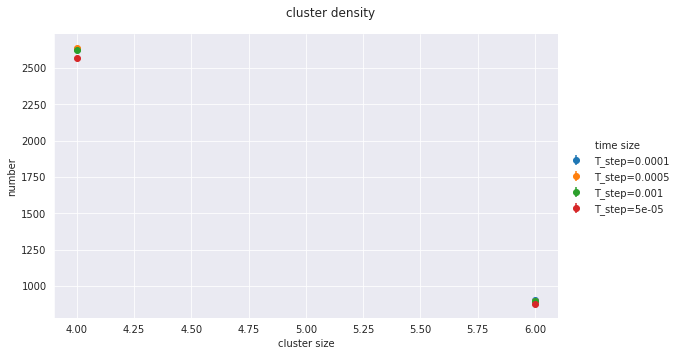

In [14]:
path = '../data/monopoles_su2/su2/su2_suzuki/48^4/beta2.8'
paths = [(f'{path}/T_step=0.0001/T_final=0.5/OR_steps=4/clusters_unwrapped', 'T_step=0.0001'), 
        (f'{path}/T_step=0.0005/T_final=0.0005/OR_steps=4/clusters_unwrapped', 'T_step=0.0005'),
        (f'{path}/T_step=0.001/T_final=0.5/OR_steps=4/clusters_unwrapped', 'T_step=0.001'),
        (f'{path}/T_step=5e-05/T_final=0.5/OR_steps=4/clusters_unwrapped', 'T_step=5e-05')]

density(1, 50, paths, 10, 'clusters_unwrapped')

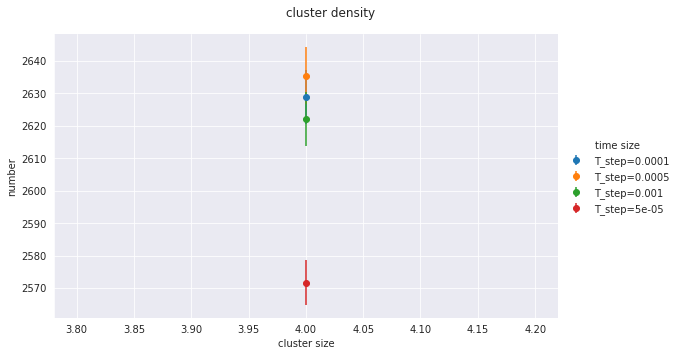

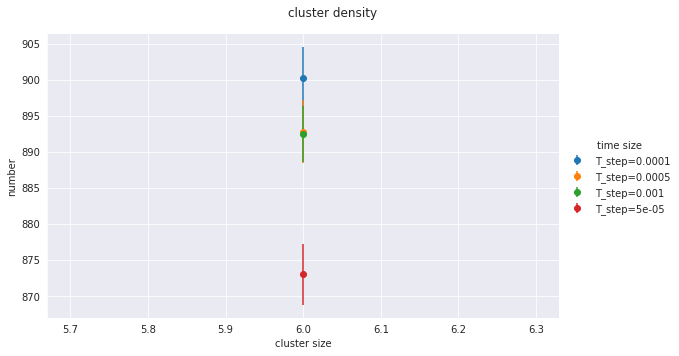

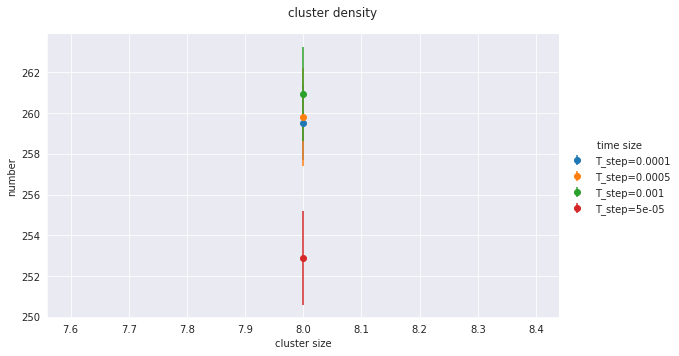

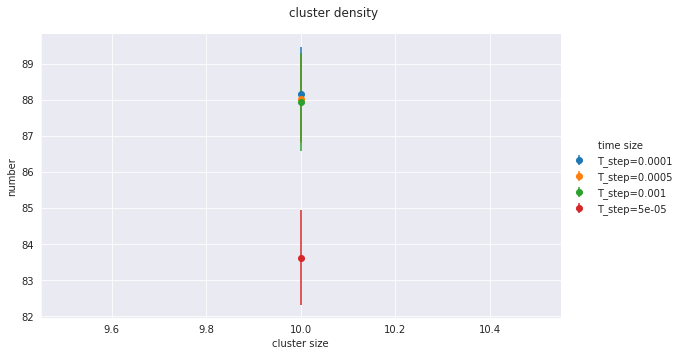

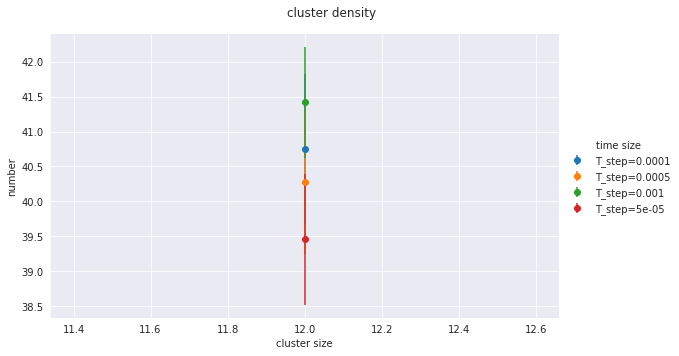

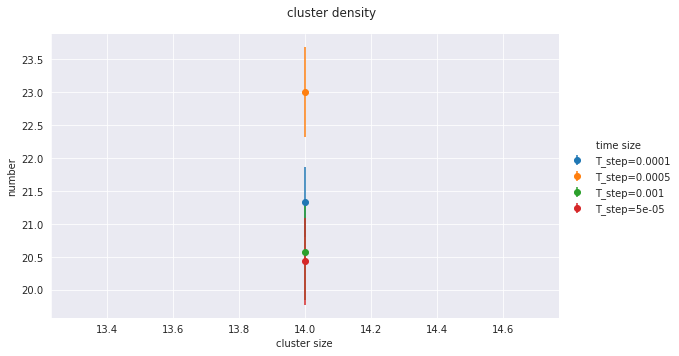

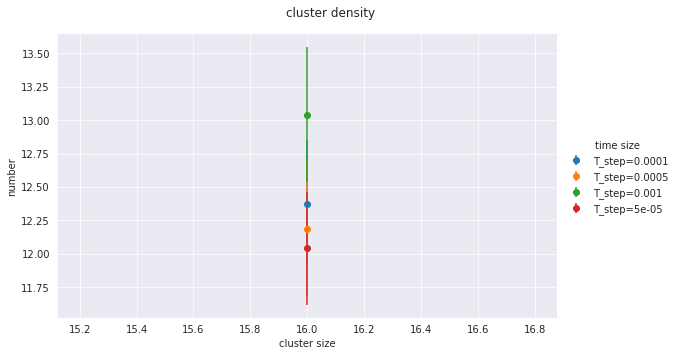

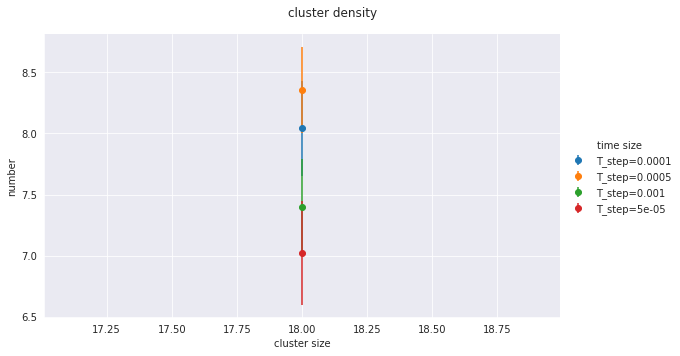

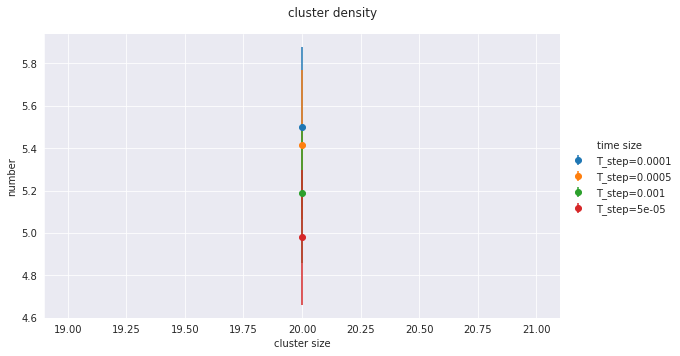

In [18]:
path = '../data/monopoles_su2/su2/su2_suzuki/48^4/beta2.8'
paths = [(f'{path}/T_step=0.0001/T_final=0.5/OR_steps=4/clusters_unwrapped', 'T_step=0.0001'), 
        (f'{path}/T_step=0.0005/T_final=0.0005/OR_steps=4/clusters_unwrapped', 'T_step=0.0005'),
        (f'{path}/T_step=0.001/T_final=0.5/OR_steps=4/clusters_unwrapped', 'T_step=0.001'),
        (f'{path}/T_step=5e-05/T_final=0.5/OR_steps=4/clusters_unwrapped', 'T_step=5e-05')]
image_path = '../images/monopoles_su2/su2_suzuki/48^4/beta2.8'
image_name = 'density_single'

density_single(1, 50, paths, 'clusters_unwrapped', 20, image_path, image_name)

In [6]:
path = '../data/monopoles_su2/su2/su2_suzuki/48^4/beta2.8'
paths = [(f'{path}/T_step=0.0001/T_final=0.5/OR_steps=4/clusters_unwrapped', 'T_step=0.0001')]

max_clusters(1, 50, paths, 'clusters_unwrapped')

   conf cluster size
         max cluster
0     1         5964
1     2          284
2     3         5872
3     4         2468
4     5         2656
5     6         2200
6     7         6720
7     8          922
8     9         7090
9    10         3366
10   11         2046
11   12         2458
12   14          452
13   15         1986
14   16         5192
15   17         8606
16   18         5922
17   19         4582
18   20         4658
19   21          530
20   22         3054
21   23         4446
22   24          466
23   25         5568
24   26         8886
25   27         3070
26   28         3508
27   29          860
28   30         6148
29   31          170
30   32         4632
31   33         5340
32   34         8964
33   35         1458
34   36          728
35   37         1478
36   38         5010
37   39          886
38   40          116
39   41          412
40   42         3430
41   43         4092
42   44         2276
43   45         9356
44   46         1424
45   48      

In [56]:
path = '../data/monopoles_su2/su2/su2_suzuki/48^4/beta2.8'
paths_unwrapped = [(f'{path}/T_step=0.0001/T_final=0.5/OR_steps=4/clusters_unwrapped', 'T_step=0.0001')]
data_unwrapped = read_data(1, 50, paths_unwrapped, 'clusters_unwrapped').reset_index(drop=True)
data_unwrapped = data_unwrapped.rename(columns={'length': 'cluster size'})
print(data_unwrapped)

      cluster size  number  conf      time size
0                4    2626     1  T_step=0.0001
1                6     883     1  T_step=0.0001
2                8     275     1  T_step=0.0001
3               10      92     1  T_step=0.0001
4               12      39     1  T_step=0.0001
...            ...     ...   ...            ...
1260            54       1    50  T_step=0.0001
1261            56       2    50  T_step=0.0001
1262            82       1    50  T_step=0.0001
1263           100       1    50  T_step=0.0001
1264           178       1    50  T_step=0.0001

[1265 rows x 4 columns]


In [8]:
def find_percolating(data, threshold):
    conf = data['conf'].iloc[0]
    if data.shape[0] >= 2:
        conf = data['conf'].iloc[0]
        data = data.sort_values(by=['cluster size'])
        if (data['cluster size'].iloc[-1] > threshold) or (data['cluster size'].iloc[-2] > threshold):
            return data.iloc[-2:]
        else: 
            return pd.DataFrame([[0, 0, 'time', conf]], columns=['cluster size', 'number', 'direction', 'conf'])
    else:
        return pd.DataFrame([[0, 0, 'time', conf]], columns=['cluster size', 'number', 'direction', 'conf'])

# def get_large_wrapped(data, threshold):
#     print(data)
#     data_time = data[data['direction'] == 'time']
#     data_space = data[data['direction'] == 'space']
#     data_both = data[data['direction'] == 'both']
#     if not data_time.empty:
#         data_time = find_percolating(data_time, threshold)
#     if not data_space.empty:
#         data_space = find_percolating(data_space, threshold)
#     if not  data_both.empty:
#         data_both = find_percolating(data_both, threshold)
#     return pd.concat([data_time, data_space, data_both])
def get_large_wrapped(data, threshold):
    data = find_percolating(data, threshold)
    return data


def clusters_divide(data_unwrapped, data_wrapped, size_threshold):
    data_large_unwrapped = data_unwrapped[data_unwrapped['cluster size'] > size_threshold]
    # print(data_wrapped)
    data_large_wrapped = data_wrapped.groupby(['conf']).apply(get_large_wrapped, size_threshold).reset_index(drop=True)
    # print(data_large_wrapped)
    # data_large_wrapped = data_large_wrapped.drop('direction', axis = 1)

    data_large = pd.concat([data_large_unwrapped, data_large_wrapped]).reset_index(drop=True)
    data_large['cluster size'] = data_large['cluster size'] * data_large['number']
    data_large = data_large.groupby(['conf'])[['cluster size']].apply(sum).reset_index()
    return data_large['cluster size'].mean()

def cluster_gap_unwrapped(data_unwrapped, data_wrapped, thresholds):
    perc_cluster_aver = []
    for threshold in thresholds:
        perc_cluster_aver.append(clusters_divide(data_unwrapped, data_wrapped, threshold))

    return perc_cluster_aver

In [31]:
def percolating_clusters(paths_unwrapped, paths_wrapped, image_path, imag_name):
    data_unwrapped = read_data(1, 50, paths_unwrapped, 'clusters_unwrapped').reset_index(drop=True)
    data_unwrapped = data_unwrapped.rename(columns={'length': 'cluster size'})
    data_unwrapped = data_unwrapped.drop('time size', axis = 1)
    data_wrapped = read_data(1, 50, paths_wrapped, 'clusters_wrapped').reset_index(drop=True)
    data_wrapped = data_wrapped.rename(columns={'length': 'cluster size'})
    data_wrapped = data_wrapped.drop('time size', axis = 1)

    # size_thresholds = [5000]
    size_thresholds = list(range(100, 10000, 50))
    perc_cluster_aver = cluster_gap_unwrapped(data_unwrapped, data_wrapped, size_thresholds)
    # print(perc_cluster_aver)
    plt.plot(size_thresholds, perc_cluster_aver);

    try:
        os.makedirs(image_path)
    except:
        pass
    plt.savefig(f'{image_path}/{imag_name}', dpi=400, facecolor='white')

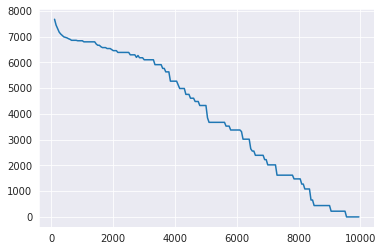

In [32]:
path = '../data/monopoles_su2/su2/su2_suzuki/48^4/beta2.8'
paths_unwrapped = [(f'{path}/T_step=0.001/T_final=0.5/OR_steps=4/clusters_unwrapped', 'T_step=0.001')]
paths_wrapped = [(f'{path}/T_step=0.001/T_final=0.5/OR_steps=4/clusters_wrapped', 'T_step=0.001')]
image_path = '../images/monopoles_su2/su2/su2_suzuki/48^4/beta2.8'
image_name = 'percolating_cluster_T_step=0p001'

percolating_clusters(paths_unwrapped, paths_wrapped, image_path, image_name)

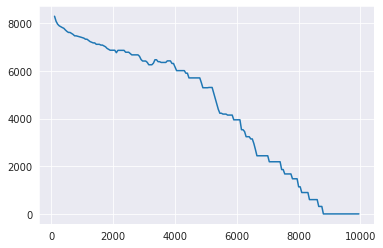

In [33]:
path = '../data/monopoles_su2/su2/su2_suzuki/48^4/beta2.8'
paths_unwrapped = [(f'{path}/T_step=0.0005/T_final=0.5/OR_steps=4/clusters_unwrapped', 'T_step=0.0005')]
paths_wrapped = [(f'{path}/T_step=0.0005/T_final=0.5/OR_steps=4/clusters_wrapped', 'T_step=0.0005')]
image_path = '../images/monopoles_su2/su2/su2_suzuki/48^4/beta2.8'
image_name = 'percolating_cluster_T_step=0p0005'

percolating_clusters(paths_unwrapped, paths_wrapped, image_path, image_name)

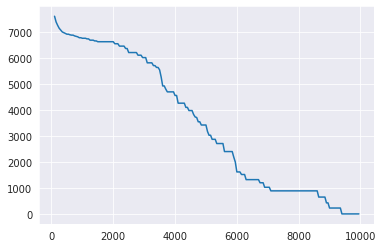

In [34]:
path = '../data/monopoles_su2/su2/su2_suzuki/48^4/beta2.8'
paths_unwrapped = [(f'{path}/T_step=0.0001/T_final=0.5/OR_steps=4/clusters_unwrapped', 'T_step=0.0001')]
paths_wrapped = [(f'{path}/T_step=0.0001/T_final=0.5/OR_steps=4/clusters_wrapped', 'T_step=0.0001')]
image_path = '../images/monopoles_su2/su2/su2_suzuki/48^4/beta2.8'
image_name = 'percolating_cluster_T_step=0p0001'

percolating_clusters(paths_unwrapped, paths_wrapped, image_path, image_name)

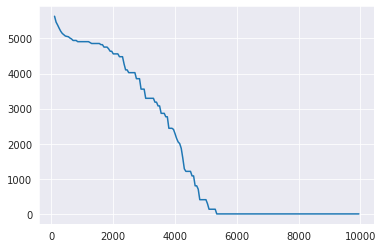

In [35]:
path = '../data/monopoles_su2/su2/su2_suzuki/48^4/beta2.8'
paths_unwrapped = [(f'{path}/T_step=5e-05/T_final=0.5/OR_steps=4/clusters_unwrapped', 'T_step=5e-05')]
paths_wrapped = [(f'{path}/T_step=5e-05/T_final=0.5/OR_steps=4/clusters_wrapped', 'T_step=5e-05')]
image_path = '../images/monopoles_su2/su2/su2_suzuki/48^4/beta2.8'
image_name = 'percolating_cluster_T_step=5e-05'

percolating_clusters(paths_unwrapped, paths_wrapped, image_path, image_name)